# Import and aggregate census information

In [138]:
# Load packages and libraries

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import uuid
import folium
from folium.plugins import MarkerCluster

projectfolder = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI/"
os.listdir(projectfolder)


['.Rhistory',
 'Datos',
 '.DS_Store',
 'Output',
 'Scripts',
 '.backups',
 'ANDI.Rproj',
 '.Rproj.user']

In [ ]:
f"{projectfolder}/Datos/1-InputData/Censo DANE 2018/11_Bogota_CSV/CNPV2018_1VIV_A2_11.CSV"
f"{projectfolder}/Datos/1-InputData/Censo DANE 2018/11_Bogota_CSV/CNPV2018_2HOG_A2_11.CSV"
f"{projectfolder}/Datos/1-InputData/Censo DANE 2018/11_Bogota_CSV/CNPV2018_1VIV_A2_11.CSV"

In [2]:
viv = pd.read_csv("/Users/upar/Downloads/11Bogota/11_Bogota_CSV/CNPV2018_1VIV_A2_11.CSV")
hogares = pd.read_csv("/Users/upar/Downloads/11Bogota/11_Bogota_CSV/CNPV2018_2HOG_A2_11.CSV")
personas = pd.read_csv("/Users/upar/Downloads/11Bogota/11_Bogota_CSV/CNPV2018_5PER_A2_11.CSV")
MGN = pd.read_csv("/Users/upar/Downloads/11Bogota/11_Bogota_CSV/CNPV2018_MGN_A2_11.CSV")

In [106]:
delito_2018 = gpd.read_file(f"{projectfolder}/Datos/2-IntermediateData/GIS/1-Delitos sexuales/delitos_sexuales-2018-points.gpkg")
delito_2018.rename(columns={'Delitos Sexuales/ IntervinientesDEL 01/01/2018 AL 31/12/2018':'ndelitos'}, inplace=True)
delito_2018.sort_values(by="FECHA_HECHO", ascending=True, inplace=True)  
delito_2018=delito_2018.drop(columns=['AÑO', 'ARMAS_MEDIOS', 'DEPTO_HECHO', 'MES', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'CLASE_SITIO', 'DESCRIPCION_CONDUCTA', 'EDAD',
       'ESTADO_CIVIL_PERSONA', 'GENERO', 'DIA_SEMANA', 'MOVIL_AGRESOR',
       'MOVIL_VICTIMA', 'ZONA', 'HORA_HECHO', 'CODIGO_DANE', 'DIRECCION_HECHO',
       'TITULO_CONDUCTA', 'PAIS_PERSONA', 'NUMERO UNICO HECHOS',
       'IDENTIFICACION', 'TIPO_IDENTIFICACION', 'LATITUD', 'LONGITUD'])
delito_2018.shape

(5023, 3)

In [134]:
# Check how many crime registers (IDs) have 1 or more crimes 
display(delito_2018.ndelitos.value_counts())

# Check how many crimes there are:
delito_2018.ndelitos.sum()

1    4993
2      19
4       4
6       2
3       2
5       2
7       1
Name: ndelitos, dtype: int64

5082

In [53]:
delito_2018['crime_id']=[str(uuid.uuid4()) for _ in range(len(delito_2018))]

<Axes: >

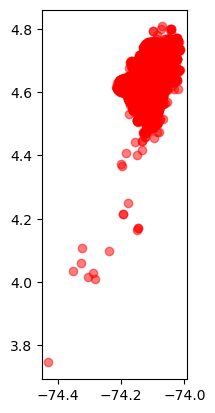

In [54]:
delito_2018.plot(color="red", alpha=0.5)

In [353]:
# Load urban sector to cut crimes outside of urban area
uarea = gpd.read_file(f"{projectfolder}/Datos/1-InputData/GIS/MGN2018_URB_AREA_CENSAL/MGN_URB_AREA_CENSAL.shp")
uarea=uarea[uarea['CPOB_CCNCT']=="11001100000000"]


<Axes: >

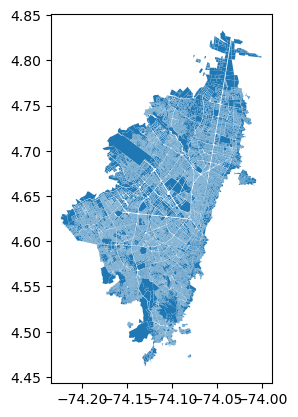

In [238]:
MANZ_shp = gpd.read_file(f"{projectfolder}/Datos/1-InputData/GIS/MGN2018_URB_MANZANA/MGN_URB_MANZANA.shp")
MANZ_shp=MANZ_shp[MANZ_shp['DPTO_CCDGO']=='11']
MANZ_shp=MANZ_shp[MANZ_shp['CPOB_CCDGO']=='11001000']
MANZ_shp.plot()

In [239]:
centroids=MANZ_shp.to_crs(3857).centroid
centroids.name = "centroid"
centroids.shape
MANZ_shp=pd.merge(MANZ_shp,centroids, left_index=True, right_index=True)
MANZ_shp.shape

(43331, 12)

# Spatial Join: Intersect

In [385]:
# Delete all crimes outside of urban area
delito_2018_u=gpd.sjoin(delito_2018, uarea, how='inner', predicate='intersects')
delito_2018_u.drop(columns='index_right', inplace=True)
delito_2018_u.columns

Index(['ndelitos', 'geometry', 'crime_id', 'DPTO_CCDGO', 'MPIO_CCDGO',
       'CLAS_CCDGO', 'SETR_CCDGO', 'SECR_CCDGO', 'CPOB_CCDGO', 'CPOB_CNMBR',
       'COD_DANE', 'CPOB_NAREA', 'CPOB_NALT', 'Shape_Leng', 'Shape_Area',
       'CPOB_CCNCT', 'ORIG_FID'],
      dtype='object')

<Axes: >

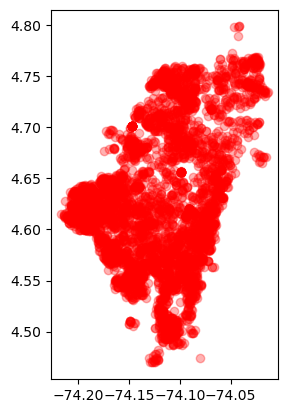

In [360]:
delito_2018_u.plot(color="red", alpha=0.3)

In [369]:
##############################################################
#  .----------------.  .----------------.  .----------------. 
# | .--------------. || .--------------. || .--------------. |
# | | _____  _____ | || |     ____     | || | _____  _____ | |
# | ||_   _||_   _|| || |   .'    `.   | || ||_   _||_   _|| |
# | |  | | /\ | |  | || |  /  .--.  \  | || |  | | /\ | |  | |
# | |  | |/  \| |  | || |  | |    | |  | || |  | |/  \| |  | |
# | |  |   /\   |  | || |  \  `--'  /  | || |  |   /\   |  | |
# | |  |__/  \__|  | || |   `.____.'   | || |  |__/  \__|  | |
# | |              | || |              | || |              | |
# | '--------------' || '--------------' || '--------------' |
#  '----------------'  '----------------'  '----------------' 

# -------------------------------------------------------------
# Observe which crimes were not in urban area

##############################################################

m=uarea.explore(color="yellow")
delito_2018[~delito_2018.crime_id.isin(delito_2018_u.crime_id)].explore(m=m, color="red")

In [400]:
#----------------------------------------------------------------------------------
# Check total number of unique crime IDs and total number of crimes
#----------------------------------------------------------------------------------
uniquecrimes = delito_2018_u.crime_id.value_counts().sum()
totalcrimes = delito_2018_u.ndelitos.sum()

uniquecrimes, totalcrimes

(4902, 4958)

In [371]:
MANZ_shp.crs == delito_2018.crs

True

In [387]:
merge= gpd.sjoin(MANZ_shp,delito_2018_u, how='left', predicate='intersects')
merge.shape

(43592, 29)

1854.0

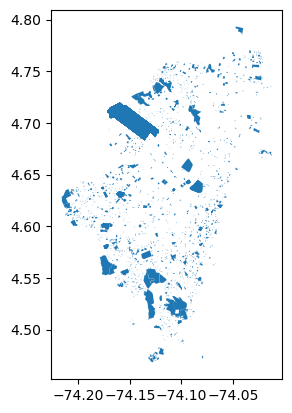

In [388]:
# Check how many crimes were joined: 1854
merge[(~merge.crime_id.isna())].plot()
merge.ndelitos.sum()

In [389]:
# Tabulate how many crime_ids are missing values.
merge.crime_id.isna().value_counts()

True     41755
False     1837
Name: crime_id, dtype: int64

In [402]:
# Check how many crimes (and which) were not joined:
joined_ids=merge[~merge.crime_id.isna()].crime_id
not_joined =  delito_2018_u[~delito_2018_u.crime_id.isin(joined_ids)]
not_joined.shape


(3065, 17)

# Merge by nearest neighbor
Those 3065 crime IDs that didn't join should now be joined using nearest centroid of the manzanas.

## Pasting crimes not joined to nearest centroid

In [229]:
#----------------------------------------------------------------
# Check that centroids were correctly created
#----------------------------------------------------------------
borrar = pd.merge(MANZ_shp,centroids, left_index=True, right_index=True)
borrar=borrar.iloc[:100,:]
m =borrar.geometry.explore(tooltip='MANZ_CCNCT')
borrar.centroid.explore(m=m, color='red')
folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

/var/folders/gh/2cf49j_x4q533sfszrhs7szc0000gn/T/ipykernel_4109/819417061.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  borrar.centroid.explore(m=m, color='red')


In [395]:
a=MANZ_shp[['MANZ_CCNCT', 'COD_AG', 'SHAPE_Leng', 'SHAPE_Area', 'COD_RDTM','centroid']].set_geometry('centroid')

In [403]:
merge2=gpd.sjoin_nearest(not_joined.to_crs(3857), a, how='inner', distance_col='distance')

In [404]:
# Check number of crimes joined with nearest
print(merge2.ndelitos.sum())

# Check number of unique crime IDs joined with nearest.
merge2.crime_id.value_counts().sum()

3104


3065

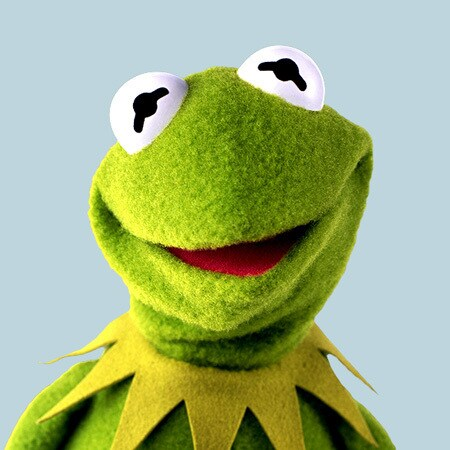

# Putting it all together


## Grouping by manzana both merges

In [407]:
merge.head()

DPTO_CCDGO_left MPIO_CCDGO_left CLAS_CCDGO_left CPOB_CCDGO_left  \
133067              11           11001               1        11001000   
133068              11           11001               1        11001000   
133069              11           11001               1        11001000   
133070              11           11001               1        11001000   
133071              11           11001               1        11001000   

                    COD_SECC              MANZ_CCNCT  COD_AG  SHAPE_Leng  \
133067  11001100000000130606  1100110000000013060611  171098    0.013655   
133068  11001100000000130606  1100110000000013060622  176899    0.003361   
133069  11001100000000130606  1100110000000013060623  176900    0.020597   
133070  11001100000000132501  1100110000000013250104  174096    0.001676   
133071  11001100000000132501  1100110000000013250109  174099    0.002261   

          SHAPE_Area                  COD_RDTM  ... SECR_CCDGO  \
133067  2.596136e-06  110011990000000013060611  ...        NaN   
133068  4.461648e-07  110011990000000013060622  ...        NaN   
133069  1.047563e-05  110011990000000013060623  ...        NaN   
133070  1.285546e-07  110011050000000013250104  ...        NaN   
133071  2.230969e-07  110011050000000013250109  ...        NaN   

       CPOB_CCDGO_right  CPOB_CNMBR  COD_DANE CPOB_NAREA CPOB_NALT Shape_Leng  \
133067              NaN         NaN       NaN        NaN       NaN        NaN   
133068              NaN         NaN       NaN        NaN       NaN        NaN   
133069              NaN         NaN       NaN        NaN       NaN        NaN   
133070              NaN         NaN       NaN        NaN       NaN        NaN   
133071              NaN         NaN       NaN        NaN       NaN        NaN   

       Shape_Area CPOB_CCNCT ORIG_FID  
133067        NaN        NaN      NaN  
133068        NaN        NaN      NaN  
133069        NaN        NaN      NaN  
133070        NaN        NaN      NaN  
133071        NaN        NaN      NaN  

[5 rows x 29 columns]

In [409]:
merge2.sort_values(by="distance", ascending=False).iloc[:10].explore()

In [410]:
mergegrp=merge.groupby(by="MANZ_CCNCT").agg({"ndelitos":"sum"})

In [411]:
merge2grp=merge2.groupby(by="MANZ_CCNCT").agg({"ndelitos":"sum"})

In [432]:
# Check that everything was done right, recall:
print(f"Total crimes: {totalcrimes}, Unique IDs: {uniquecrimes}")

print(f"> Total crimes after processing: {mergegrp.sum()+merge2grp.sum()}");


Total crimes: 4958, Unique IDs: 4902
> Total crimes after processing: ndelitos    4958.0
dtype: float64


## Merge after grouping by

In [449]:
t=pd.merge(mergegrp, merge2grp, left_index=True, right_index=True, how='outer')
t['ndelitos'] = t['ndelitos_x'].fillna(0) + t['ndelitos_y'].fillna(0)
t

ndelitos_x  ndelitos_y  ndelitos
MANZ_CCNCT                                              
1100110000000011010101         1.0         NaN       1.0
1100110000000011010102         0.0         NaN       0.0
1100110000000011010103         5.0         NaN       5.0
1100110000000011010104         0.0         NaN       0.0
1100110000000011010105         0.0         NaN       0.0
...                            ...         ...       ...
1100110000000092220718         0.0         NaN       0.0
1100110000000092220719         0.0         NaN       0.0
1100110000000092220720         0.0         NaN       0.0
1100110000000092220721         0.0         NaN       0.0
1100110000000092220722         0.0         NaN       0.0

[43331 rows x 3 columns]

In [454]:
t.drop(columns=['ndelitos_x', 'ndelitos_y'], inplace=True)
t['ndelitos'].sum()

4958.0

## Join dataframe to spatial information

In [458]:
M=pd.merge(MANZ_shp, t, left_on="MANZ_CCNCT", right_index=True, how='outer')
M

DPTO_CCDGO MPIO_CCDGO CLAS_CCDGO CPOB_CCDGO              COD_SECC  \
133067         11      11001          1   11001000  11001100000000130606   
133068         11      11001          1   11001000  11001100000000130606   
133069         11      11001          1   11001000  11001100000000130606   
133070         11      11001          1   11001000  11001100000000132501   
133071         11      11001          1   11001000  11001100000000132501   
...           ...        ...        ...        ...                   ...   
504080         11      11001          1   11001000  11001100000000810901   
504081         11      11001          1   11001000  11001100000000810901   
504082         11      11001          1   11001000  11001100000000810901   
504083         11      11001          1   11001000  11001100000000810901   
504084         11      11001          1   11001000  11001100000000810901   

                    MANZ_CCNCT  COD_AG  SHAPE_Leng    SHAPE_Area  \
133067  1100110000000013060611  171098    0.013655  2.596136e-06   
133068  1100110000000013060622  176899    0.003361  4.461648e-07   
133069  1100110000000013060623  176900    0.020597  1.047563e-05   
133070  1100110000000013250104  174096    0.001676  1.285546e-07   
133071  1100110000000013250109  174099    0.002261  2.230969e-07   
...                        ...     ...         ...           ...   
504080  1100110000000081090110  155365    0.002346  1.824002e-07   
504081  1100110000000081090111  155496    0.003463  3.571889e-07   
504082  1100110000000081090112  155438    0.001378  1.183685e-07   
504083  1100110000000081090113  155536    0.006456  2.373622e-06   
504084  1100110000000081090115  155262    0.004503  7.085492e-07   

                        COD_RDTM  \
133067  110011990000000013060611   
133068  110011990000000013060622   
133069  110011990000000013060623   
133070  110011050000000013250104   
133071  110011050000000013250109   
...                          ...   
504080  110011030000000081090110   
504081  110011030000000081090111   
504082  110011030000000081090112   
504083  110011030000000081090113   
504084  110011030000000081090115   

                                                 geometry  \
133067  POLYGON ((-74.10166 4.54585, -74.10164 4.54583...   
133068  POLYGON ((-74.09826 4.54145, -74.09820 4.54144...   
133069  POLYGON ((-74.10195 4.54583, -74.10193 4.54583...   
133070  POLYGON ((-74.09125 4.51603, -74.09125 4.51598...   
133071  POLYGON ((-74.09160 4.51642, -74.09159 4.51637...   
...                                                   ...   
504080  POLYGON ((-74.06805 4.61661, -74.06800 4.61659...   
504081  POLYGON ((-74.06803 4.61624, -74.06802 4.61624...   
504082  POLYGON ((-74.06844 4.61640, -74.06833 4.61637...   
504083  POLYGON ((-74.06795 4.61596, -74.06786 4.61592...   
504084  POLYGON ((-74.06709 4.61697, -74.06701 4.61695...   

                               centroid  ndelitos  
133067  POINT (-8248717.170 506323.420)       0.0  
133068  POINT (-8248595.565 506064.876)       0.0  
133069  POINT (-8248812.031 506231.720)       0.0  
133070  POINT (-8247814.477 503274.269)       0.0  
133071  POINT (-8247862.040 503278.961)       0.0  
...                                 ...       ...  
504080  POINT (-8245216.199 514466.226)       0.0  
504081  POINT (-8245131.249 514397.387)       0.0  
504082  POINT (-8245256.973 514434.343)       0.0  
504083  POINT (-8245190.354 514321.417)       1.0  
504084  POINT (-8245175.433 514501.133)       0.0  

[43331 rows x 13 columns]

<Axes: >

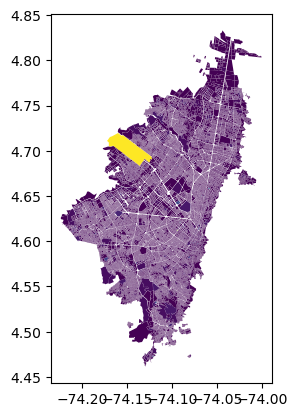

In [463]:
M.plot(column='ndelitos')

In [470]:
M.sort_values(by='ndelitos', ascending=False).iloc[:100].explore()

In [471]:
                                                                   
                                                                   
# EEEEEEEEEEEEEEEEEEEEEENNNNNNNN        NNNNNNNNDDDDDDDDDDDDD        
# E::::::::::::::::::::EN:::::::N       N::::::ND::::::::::::DDD     
# E::::::::::::::::::::EN::::::::N      N::::::ND:::::::::::::::DD   
# EE::::::EEEEEEEEE::::EN:::::::::N     N::::::NDDD:::::DDDDD:::::D  
#   E:::::E       EEEEEEN::::::::::N    N::::::N  D:::::D    D:::::D 
#   E:::::E             N:::::::::::N   N::::::N  D:::::D     D:::::D
#   E::::::EEEEEEEEEE   N:::::::N::::N  N::::::N  D:::::D     D:::::D
#   E:::::::::::::::E   N::::::N N::::N N::::::N  D:::::D     D:::::D
#   E:::::::::::::::E   N::::::N  N::::N:::::::N  D:::::D     D:::::D
#   E::::::EEEEEEEEEE   N::::::N   N:::::::::::N  D:::::D     D:::::D
#   E:::::E             N::::::N    N::::::::::N  D:::::D     D:::::D
#   E:::::E       EEEEEEN::::::N     N:::::::::N  D:::::D    D:::::D 
# EE::::::EEEEEEEE:::::EN::::::N      N::::::::NDDD:::::DDDDD:::::D  
# E::::::::::::::::::::EN::::::N       N:::::::ND:::::::::::::::DD   
# E::::::::::::::::::::EN::::::N        N::::::ND::::::::::::DDD     
# EEEEEEEEEEEEEEEEEEEEEENNNNNNNN         NNNNNNNDDDDDDDDDDDDD        



# Tablero

In [27]:
# MGN_manzana = gpd.read_file("/Users/upar/Downloads/MGN2018_URB_MANZANA/MGN_URB_MANZANA.shp")
bogMGN=MGN_manzana[MGN_manzana['DPTO_CCDGO']=='11']

In [18]:
MGN_manzana.head() #['COD_CPOB'] #.COD_MPIO =="11"

COD_DPTO COD_MPIO COD_CLASE  COD_CPOB              COD_SECC  \
0       05    05001         1  05001000  05001100000000010101   
1       05    05001         1  05001000  05001100000000010101   
2       05    05001         1  05001000  05001100000000010101   
3       05    05001         1  05001000  05001100000000010101   
4       05    05001         1  05001000  05001100000000010101   

                 COD_DANE  COD_AG  TIPO_CTSTR      COD_CTSTR  ANO_VGNC  ...  \
0  0500110000000001010101  000001           5   050010101105      2021  ...   
1  0500110000000001010104  000002           5   050010101064      2021  ...   
2  0500110000000001010105  000003           5   050010101063      2021  ...   
3  0500110000000001010108  000004           5   050010101061      2021  ...   
4  0500110000000001010109  000005           5  0500100101100      2021  ...   

  TIPO_ACTLZ ANO_ACTLZ  REVI_CAMPO      LATI       LONG  VIV  SHAPE_Leng  \
0          0         0           0  6.301288 -75.542563   34    0.003371   
1          0         0           0  6.299384 -75.542372   53    0.002620   
2          0         0           0  6.299333 -75.542817   73    0.003002   
3          0         0           0  6.299935 -75.543699   48    0.001944   
4          0         0           0  6.298994 -75.544830    3    0.001469   

     SHAPE_Area    FT_ACT_VIV  \
0  2.313257e-07  VIV_CNPV2018   
1  1.629524e-07  VIV_CNPV2018   
2  2.090910e-07  VIV_CNPV2018   
3  1.573086e-07  VIV_CNPV2018   
4  9.901152e-08  VIV_CNPV2018   

                                            geometry  
0  POLYGON ((-75.54267 6.30182, -75.54262 6.30175...  
1  POLYGON ((-75.54237 6.29968, -75.54235 6.29965...  
2  POLYGON ((-75.54280 6.29964, -75.54277 6.29959...  
3  POLYGON ((-75.54386 6.29974, -75.54386 6.29975...  
4  POLYGON ((-75.54481 6.29881, -75.54487 6.29874...  

[5 rows x 26 columns]

In [19]:
# 1. Filtrar el MGN por departamento Bogotá (y centro poblado) 
# 2. Filtra por área urbana de Bogotá ()
# 3. Pegar censo y MGN left_on="COD_DANE_ANM", right_on="MANZ_CCNCT"

In [22]:
MGN.head()

U_DPTO  U_MPIO  UA_CLASE  UA1_LOCALIDAD  U_SECT_RUR  U_SECC_RUR  UA2_CPOB  \
0      11       1         1              1           0           0         0   
1      11       1         1              1           0           0         0   
2      11       1         1              1           0           0         0   
3      11       1         1              1           0           0         0   
4      11       1         1              1           0           0         0   

   U_SECT_URB  U_SECC_URB  U_MZA  U_EDIFICA  COD_ENCUESTAS  U_VIVIENDA  \
0        8401           1      2          2       17590967           1   
1        8401           1      3          1      900395117           1   
2        8401           1      3          2       15720976           1   
3        8401           1      3          3       17590954           1   
4        8401           1      3          4       16037871           1   

             COD_DANE_ANM  
0  1100110000000084010102  
1  1100110000000084010103  
2  1100110000000084010103  
3  1100110000000084010103  
4  1100110000000084010103

<Axes: >

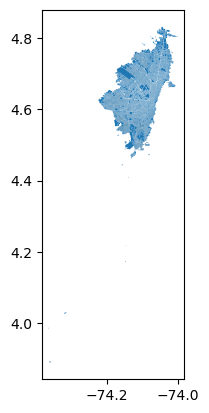

In [28]:
bogMGN.plot()

In [72]:
MGN.groupby(by="COD_DANE_ANM").agg({"COD_DANE_ANM":"count"})

COD_DANE_ANM
COD_DANE_ANM                        
1100110000000000000000           894
1100110000000011010101             4
1100110000000011010102           141
1100110000000011010103           373
1100110000000011010104           906
...                              ...
1100130111700000000000             4
1100130112100000000000             2
1100130112200000000000             1
1100130113000000000000             1
1100130113500000000000             7

[38859 rows x 1 columns]

In [74]:
merge=pd.merge(bogMGN,MGN.groupby(by="COD_DANE_ANM").agg({"COD_DANE_ANM":"count"}), left_on="MANZ_CCNCT", right_index=True, how='left')

In [70]:
bogMGN.MANZ_CCNCT

133067    1100110000000013060611
133068    1100110000000013060622
133069    1100110000000013060623
133070    1100110000000013250104
133071    1100110000000013250109
                   ...          
504080    1100110000000081090110
504081    1100110000000081090111
504082    1100110000000081090112
504083    1100110000000081090113
504084    1100110000000081090115
Name: MANZ_CCNCT, Length: 43331, dtype: object

In [77]:
merge.shape

(43331, 12)

<Axes: >

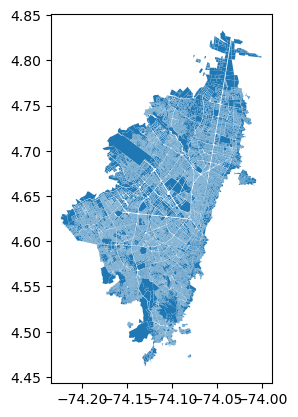

In [78]:
merge.plot()